In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.spatial.distance import mahalanobis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import pingouin as pg

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('dataset.csv')
    print(f"Đã load dữ liệu thành công. Kích thước: {df.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'dataset.csv'. Hãy đảm bảo bạn đã chạy script tạo dữ liệu ở bước trước.")

Đã load dữ liệu thành công. Kích thước: (355, 15)


### 1. Tiền xử lý dữ liệu (Dữ liệu khuyết & Ngoại lai)

In [2]:
# 1. Xử lý dữ liệu khuyết
imputer = IterativeImputer(max_iter=10, random_state=0)
df_clean = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 2. Kiểm tra giá trị ngoại lai bằng khoảng cách Mahalanobis
# Tính ma trận hiệp phương sai nghịch đảo
cov = np.cov(df_clean.T)
try:
    inv_cov = np.linalg.inv(cov)
except np.linalg.LinAlgError:
    # Trường hợp ma trận nghịch đảo bị lỗi (ít gặp với dữ liệu này), dùng giả nghịch đảo
    inv_cov = np.linalg.pinv(cov)

mean = df_clean.mean()

# Tính khoảng cách cho từng điểm dữ liệu
dist = df_clean.apply(lambda row: mahalanobis(row, mean, inv_cov), axis=1)

# Tính p-value từ phân phối Chi-square
p_values = 1 - stats.chi2.cdf(dist**2, df=df_clean.shape[1])

# Loại bỏ các quan sát có p-value < 0.001
df_final = df_clean[p_values > 0.001]

print(f"Số lượng quan sát ban đầu: {len(df)}")
print(f"Số lượng quan sát sau khi loại bỏ ngoại lai: {len(df_final)}")

Số lượng quan sát ban đầu: 355
Số lượng quan sát sau khi loại bỏ ngoại lai: 350


### 2. Thống kê mô tả

In [3]:
# Tính toán các chỉ số thống kê mô tả
desc = df_final.describe().T[['mean', 'std', 'count']]
desc['skewness'] = df_final.skew()
desc['kurtosis'] = df_final.kurt()

# Hiển thị bảng kết quả
print(desc[['mean', 'std', 'skewness', 'kurtosis', 'count']])

         mean       std  skewness  kurtosis  count
Q1   4.520000  1.122012 -0.123665  0.096550  350.0
Q2   4.100000  1.053715 -0.008867 -0.081731  350.0
Q3   3.948571  1.151894 -0.170650  0.004082  350.0
Q4   4.020000  1.079717  0.015078 -0.200097  350.0
Q5   4.148571  0.981599 -0.374863  0.102579  350.0
Q6   3.880000  1.251887 -0.097661 -0.086527  350.0
Q7   4.200000  1.024066 -0.135242 -0.269641  350.0
Q8   3.751429  1.301723  0.022696 -0.404929  350.0
Q9   4.348571  1.101541  0.078359 -0.259202  350.0
Q10  4.051429  1.061267  0.142986  0.070677  350.0
Q11  3.920000  1.184620 -0.042087  0.060897  350.0
Q12  4.180000  1.003804 -0.025465  0.042380  350.0
Q13  4.400000  0.948532 -0.267444  0.064916  350.0
Q14  4.251429  1.040545 -0.073125  0.216564  350.0
Q15  3.891429  1.201568 -0.367841 -0.217662  350.0


### 3. Kiểm tra tính phù hợp (Ma trận tương quan)

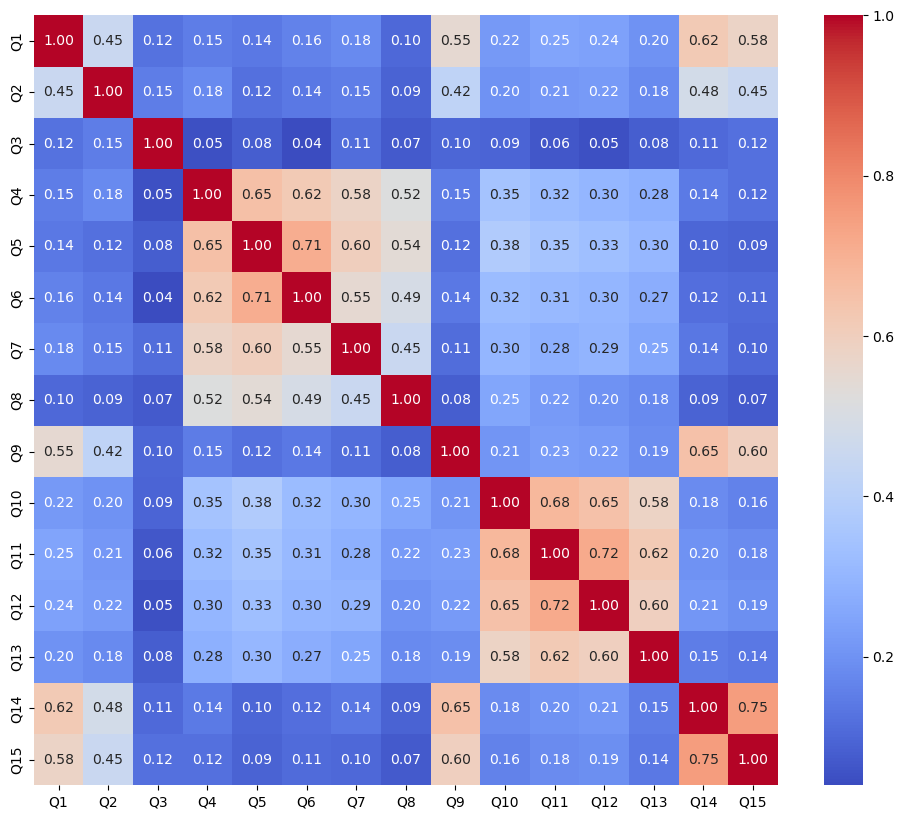

Determinant of R: 7.81e-04


In [4]:
# Tính ma trận tương quan
corr_matrix = df_final.corr()

# Hiển thị ma trận dưới dạng Heatmap hoặc bảng số
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Hiển thị giá trị định thức của ma trận R
det_R = np.linalg.det(corr_matrix)
print(f"Determinant of R: {det_R:.2e}")

### 4. Kiểm định KMO và Bartlett

In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Kiểm định Bartlett
chi_square_value, p_value = calculate_bartlett_sphericity(df_final)
print(f"Bartlett p-value: {p_value}")

# Chỉ số KMO
kmo_all, kmo_model = calculate_kmo(df_final)
print(f"KMO Model: {kmo_model}")

# Tính toán kiểm định Bartlett
chi_square_value, p_value = calculate_bartlett_sphericity(df_final)

print("Bartlett's Test of Sphericity")
print(f"Approx. Chi-Square: {chi_square_value:.3f}") # Kết quả thực tế từ dữ liệu
print(f"df: {df_final.shape[1] * (df_final.shape[1] - 1) / 2:.0f}") # Degrees of freedom = p(p-1)/2 = 15*14/2 = 105
print(f"Sig.: {p_value:.3f}")

Bartlett p-value: 0.0
KMO Model: 0.887287074902181
Bartlett's Test of Sphericity
Approx. Chi-Square: 2455.218
df: 105
Sig.: 0.000


### 5. Tiêu chí xác định số lượng nhân tố (Scree Plot)

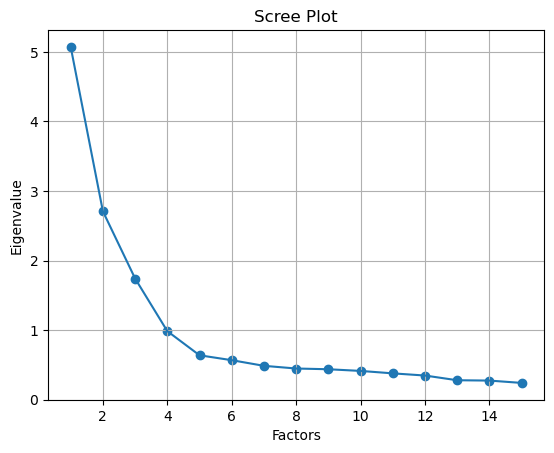

In [6]:
# Khởi tạo mô hình
fa = FactorAnalyzer(n_factors=15, rotation=None)
fa.fit(df_final)

# Lấy Eigenvalues
ev, v = fa.get_eigenvalues()

# Vẽ Scree Plot
plt.scatter(range(1, df_final.shape[1]+1), ev)
plt.plot(range(1, df_final.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### 6. Tổng phương sai trích

In [7]:
# Lấy giá trị phương sai của các nhân tố
variance_info = fa.get_factor_variance()

variance_df = pd.DataFrame(variance_info, 
                           index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                           columns=[f'Factor {i+1}' for i in range(15)])

# Chỉ hiển thị 3 nhân tố đầu tiên (để khớp với nội dung cần quan tâm)
print(variance_df.iloc[:, :3].T)

# Hoặc nếu muốn xem toàn bộ bảng như Table variance trong báo cáo:
# print(variance_df.T)

          SS Loadings  Proportion Var  Cumulative Var
Factor 1     4.749811        0.316654        0.316654
Factor 2     2.387900        0.159193        0.475847
Factor 3     1.427105        0.095140        0.570988


### 7. Ma trận hệ số tải (Initial Loadings - Chưa xoay)

In [8]:
# Trích xuất hệ số tải (Loadings)
loadings = pd.DataFrame(fa.loadings_[:, :3], 
                        index=df_final.columns, 
                        columns=[f'F{i+1}' for i in range(3)])

# Hiển thị các hệ số tải lớn hơn 0.3 (để dễ quan sát)
print(loadings[abs(loadings) > 0.3].fillna('-'))

           F1        F2        F3
Q1    0.51475  0.524689         -
Q2    0.43655  0.394691         -
Q3          -         -         -
Q4   0.644079  -0.36577  0.323828
Q5   0.666654 -0.439525  0.310056
Q6   0.625805 -0.374837  0.321985
Q7   0.584374 -0.322809         -
Q8    0.47687  -0.31745         -
Q9   0.489719  0.554297         -
Q10   0.66393         - -0.425192
Q11  0.687699         - -0.511735
Q12  0.668954         - -0.497204
Q13  0.582783         - -0.431034
Q14  0.526706  0.694294         -
Q15  0.483723  0.657802         -


### 8. Tính cộng đồng (Communalities)

In [9]:
# Lấy hệ số cộng đồng
communalities = fa.get_communalities()

# Tạo bảng so sánh
comm_df = pd.DataFrame({
    'Variable': df_final.columns,
    'Extraction': communalities
})
print(comm_df)

   Variable  Extraction
0        Q1    0.614707
1        Q2    0.450945
2        Q3    0.187971
3        Q4    0.730000
4        Q5    0.770544
5        Q6    0.683057
6        Q7    0.616892
7        Q8    0.465752
8        Q9    0.604633
9       Q10    0.682804
10      Q11    0.777259
11      Q12    0.746456
12      Q13    0.580541
13      Q14    0.834202
14      Q15    0.737637


### 9. Phương pháp xoay (Promax) - Ma trận tương quan & Pattern Matrix

In [10]:
fa = FactorAnalyzer(n_factors=3, rotation='promax', method='ml')
fa.fit(df_final)

factor_corr_matrix = pd.DataFrame(fa.phi_, 
                                  index=[f'F{i+1}' for i in range(3)], 
                                  columns=[f'F{i+1}' for i in range(3)])
print("Factor Correlation Matrix:\n", factor_corr_matrix)

rotated_loadings = pd.DataFrame(fa.loadings_, 
                                index=df_final.columns, 
                                columns=[f'F{i+1}' for i in range(3)])
print("\nRotated Factor Loadings:\n", rotated_loadings)

Factor Correlation Matrix:
           F1        F2        F3
F1  1.000000  0.375821  0.487202
F2  0.375821  1.000000  0.285516
F3  0.487202  0.285516  1.000000

Rotated Factor Loadings:
            F1        F2        F3
Q1   0.709632 -0.012846  0.028257
Q2   0.543165  0.007386  0.050385
Q3   0.127165  0.046864  0.015438
Q4   0.010419  0.769440  0.013010
Q5  -0.057145  0.858973  0.031882
Q6  -0.009739  0.811833 -0.011664
Q7   0.015127  0.699926  0.006970
Q8  -0.017289  0.661077 -0.046508
Q9   0.744345 -0.044256  0.009622
Q10 -0.011588  0.053617  0.769254
Q11 -0.002999 -0.031073  0.878623
Q12  0.014740 -0.033734  0.838935
Q13 -0.020166 -0.007038  0.735040
Q14  0.930114 -0.058659 -0.085350
Q15  0.874911 -0.065446 -0.082195


### 10. Chạy lại mô hình EFA chính thức (ML + Promax)

In [11]:
fa = FactorAnalyzer(n_factors=3, rotation='promax', method='ml')
fa.fit(df_final)

# Lấy ma trận hệ số tải sau khi xoay (Rotated Loadings)
loadings = fa.loadings_

# Lấy ma trận tương quan giữa các nhân tố (Factor Correlation Matrix)
factor_corr = fa.phi_

### 11. Kiểm định độ tin cậy Cronbach's Alpha

In [12]:
import pingouin as pg

# Định nghĩa các nhóm biến thuộc từng nhân tố
f1_vars = ['Q3', 'Q4', 'Q5', 'Q6', 'Q7']       # Sức khỏe Tinh thần
f2_vars = ['Q9', 'Q10', 'Q11', 'Q12']          # Quan hệ Xã hội
f3_vars = ['Q1', 'Q2', 'Q8', 'Q13', 'Q14', 'Q15'] # Khả năng Tự chủ

# Tính Cronbach's Alpha
alpha_f1 = pg.cronbach_alpha(data=df_final[f1_vars])[0]
alpha_f2 = pg.cronbach_alpha(data=df_final[f2_vars])[0]
alpha_f3 = pg.cronbach_alpha(data=df_final[f3_vars])[0]

print(f"Alpha F1: {alpha_f1}, Alpha F2: {alpha_f2}, Alpha F3: {alpha_f3}")

Alpha F1: 0.7586689694534519, Alpha F2: 0.7640981686868131, Alpha F3: 0.7136345191157578
